# TensorFlow Basics

## Tensors

In [80]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

x = tf.constant([
    [1., 2., 3.],
    [4., 5., 6.],
])

print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


In [81]:
x + x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [82]:
5 * x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5., 10., 15.],
       [20., 25., 30.]], dtype=float32)>

In [83]:
x @ tf.transpose(x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [84]:
tf.concat([x, x, x], axis=0)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [85]:
tf.concat([x, x, x], axis=1)

<tf.Tensor: shape=(2, 9), dtype=float32, numpy=
array([[1., 2., 3., 1., 2., 3., 1., 2., 3.],
       [4., 5., 6., 4., 5., 6., 4., 5., 6.]], dtype=float32)>

In [86]:
tf.nn.softmax(x, axis=-1)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.09003057, 0.24472848, 0.66524094],
       [0.09003057, 0.24472848, 0.66524094]], dtype=float32)>

In [87]:
tf.reduce_sum(x)

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

In [88]:
tf.reduce_sum(x, axis=-1, keepdims=True)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 6.],
       [15.]], dtype=float32)>

In [89]:
tf.convert_to_tensor([1, 2, 3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [90]:
tf.reduce_sum([1, 2, 3])

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [91]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


## Variables

In [92]:
var = tf.Variable([0.0, 0.0, 0.0])
var

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [93]:
var.assign([1, 2, 3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [94]:
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

## Automatic differentiation

In [95]:
x = tf.Variable(1.0)

def f(x):
    y = x**2 + 2*x - 5
    return y

In [96]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [97]:
with tf.GradientTape() as tape:
    y = f(x)

g_x = tape.gradient(y, x) # g(x) = dy/dx

g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

## Graphs and tf.function

In [98]:
@tf.function
def my_func(x):
    print('Tracing.\n')
    return tf.reduce_sum(x)

In [99]:
x = tf.constant([1, 2, 3])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [100]:
x = tf.constant([10, 9, 8])
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

In [101]:
x = tf.constant([10.0, 9.1, 8,2], dtype=tf.float32)
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=29.1>

## Modules, layers, and models

In [102]:
class MyModule(tf.Module):
    def __init__(self, value):
        self.weight = tf.Variable(value)

    @tf.function
    def multiply(self, x):
        return x * self.weight

In [103]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

In [104]:
save_path = '../../models/saved_model'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ../../models/saved_model/assets


INFO:tensorflow:Assets written to: ../../models/saved_model/assets


In [105]:
reloaded = tf.saved_model.load(save_path)

In [106]:
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

## Training loops

In [107]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

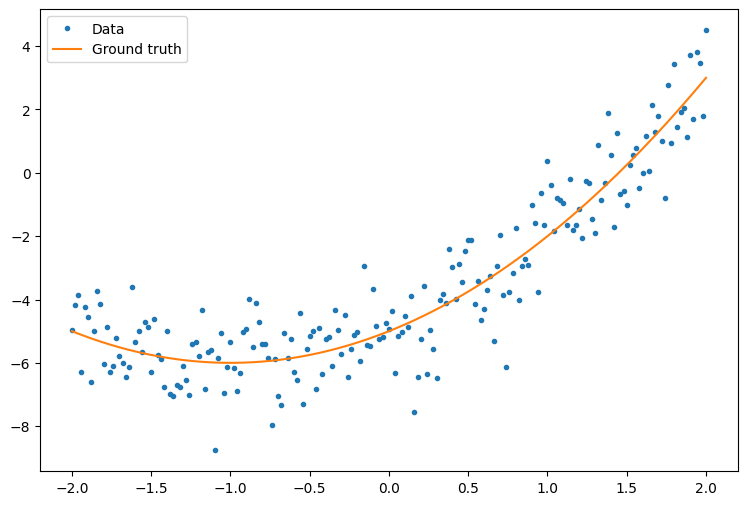

In [108]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
    y = x**2 + 2*x - 5
    return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

In [109]:
class Model(tf.Module):
    def __init__(self):
        # Randomly generate weight and bias terms
        rand_init = tf.random.uniform(shape=[3], minval=0.0, maxval=5., seed=22)
        # Initialize model parameters
        self.w_q = tf.Variable(rand_init[0])
        self.w_l = tf.Variable(rand_init[1])
        self.b = tf.Variable(rand_init[2])

    @tf.function
    def __call__(self, x):
        # Quadratic Model: quadratic_weight * x^2 + linear_weight * x + bias
        return self.w_q * (x**2) + self.w_l * x + self.b

In [110]:
quad_model = Model()

In [111]:
def plot_preds(x, y, f, model, title):
    plt.figure()
    plt.plot(x, y, '.', label='Data')
    plt.plot(x, f(x), label='Ground truth')
    plt.plot(x, model(x), label='Predictions')
    plt.title(title)
    plt.legend()

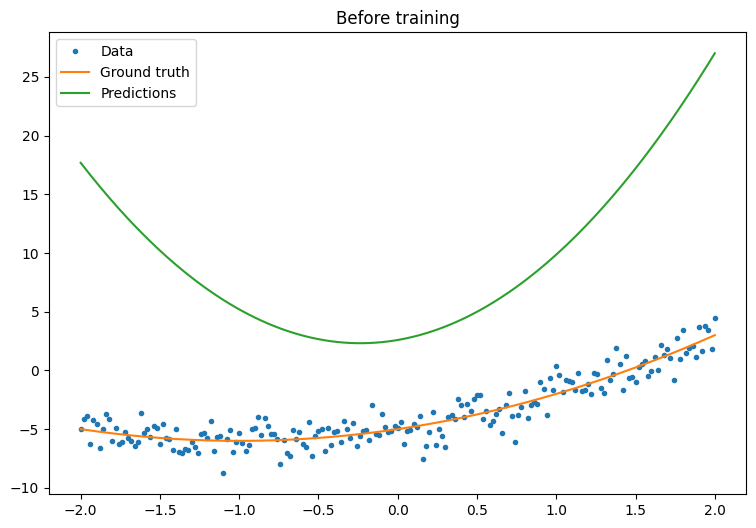

In [112]:
plot_preds(x, y, f, quad_model, 'Before training')

In [113]:
def mse_loss(y_pred, y):
    return tf.reduce_mean(tf.square(y - y_pred))

In [114]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

2024-11-18 19:24:27.068320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.099080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.122872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.153787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.183324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.212287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.239277: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 0: 64.004


2024-11-18 19:24:27.290094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.324899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.360099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.399599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.427594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.453299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.486707: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 10: 4.286


2024-11-18 19:24:27.523117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.549742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.572909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.594661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.614649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.635341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.655321: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 20: 2.175


2024-11-18 19:24:27.746808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.770571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.795678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.825164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.857532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.880037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.900462: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 30: 1.434


2024-11-18 19:24:27.973572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:27.993812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.017169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.040329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.064371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.097296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.138186: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 40: 1.177


2024-11-18 19:24:28.191902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.220058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.252914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.287519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.321600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.342287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.366983: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 50: 1.086


2024-11-18 19:24:28.639174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.675763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.705440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.726869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.748881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.777199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.816213: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 60: 1.052


2024-11-18 19:24:28.869120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.922753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:28.976457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.057061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.090847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.119288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.140269: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 70: 1.039


2024-11-18 19:24:29.296570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.317554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.341833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.364548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.393548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.455957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.477860: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 80: 1.038


2024-11-18 19:24:29.499696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.526661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.549208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.582825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.614212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.635131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.655648: W tensorflow/core/framework/local_rendezvous.cc:404] L

Mean squared error for step 90: 1.036




2024-11-18 19:24:29.730423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.760653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.787187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.810568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.831546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-18 19:24:29.856064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 1.0, 'MSE loss vs training iterations')

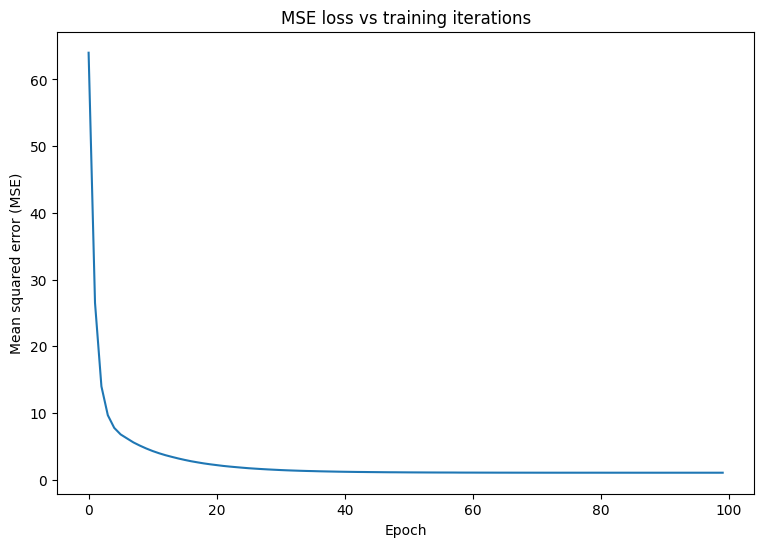

In [115]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
    for x_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            batch_loss = mse_loss(quad_model(x_batch), y_batch)
        # Update parameters with respect to the gradient calculations
        grads = tape.gradient(batch_loss, quad_model.variables)
        for g, v in zip(grads, quad_model.variables):
            v.assign_sub(learning_rate * g)
    # Keep track of model loss per epoch
    loss = mse_loss(quad_model(x), y)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Mean squared error (MSE)')
plt.title('MSE loss vs training iterations')

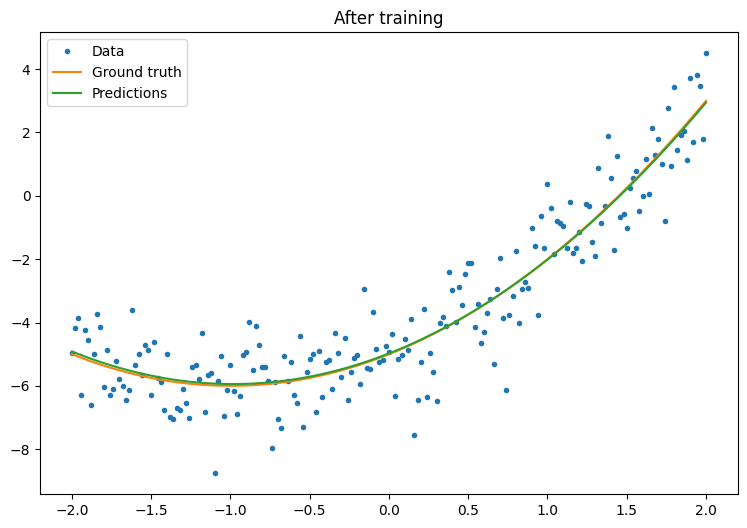

In [116]:
plot_preds(x, y, f, quad_model, 'After training')

In [117]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

In [118]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
)

history = new_model.fit(
    x, y, epochs=100, batch_size=32
)

new_model.save('../../models/my_new_model.keras')

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.6682
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.9051
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2345
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5019
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2717
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5367
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7687
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 5.2118
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3792
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2410
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 4.0697
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5768  
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4408
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7979
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6755
Epoch 16/100
7/7 ━━━━━━━━

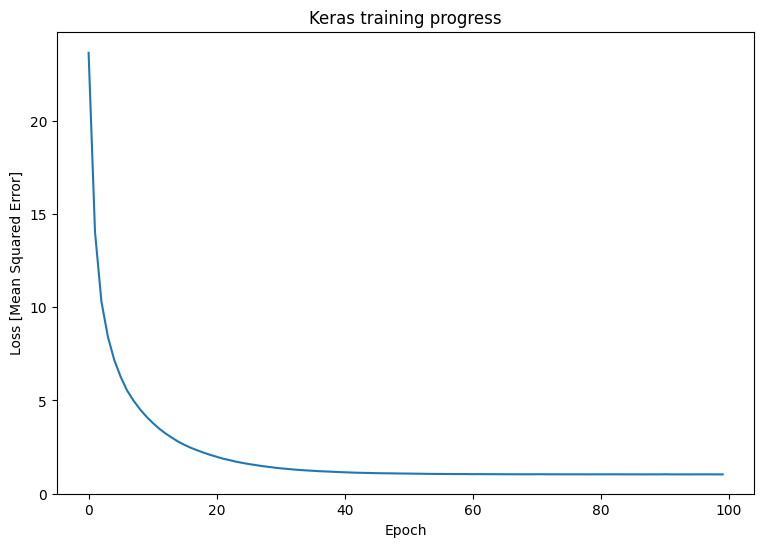

In [119]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

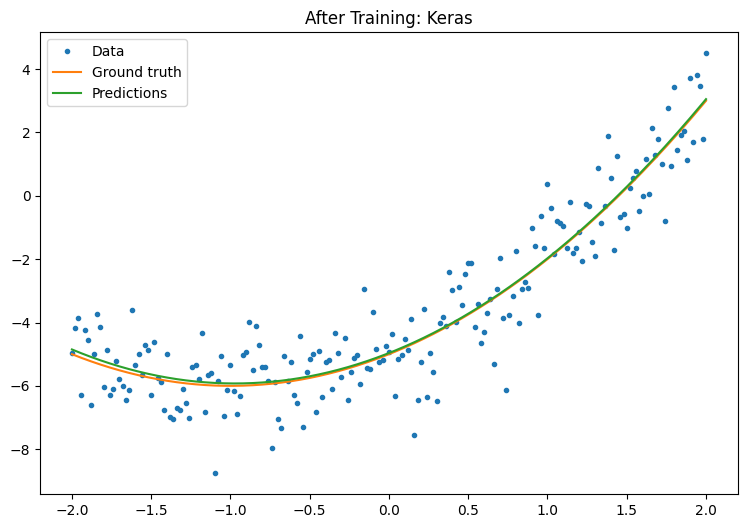

In [120]:
plot_preds(x, y, f, new_model, 'After Training: Keras')